# Basic

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from wordcloud import STOPWORDS
import nltk
import string

In [137]:
import pandas as pd
import io
from google.colab import files

In [138]:
#files.upload()

In [139]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [140]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

fake-and-real-news-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [141]:
from zipfile import ZipFile
file_name = 'fake-and-real-news-dataset.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Get an overview of both CSVs and merge them together!
The data is provided in two separated csv files. One file contains real articles, the other file contains fake news. Let's get an idea of both files.

In [142]:
fake = pd.read_csv('/content/Fake.csv')
news = pd.read_csv('/content/True.csv')

In [143]:
import nltk

In [144]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Let's take a look at Real News

In [145]:
news

title  ...                date
0      As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1      U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2      Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3      FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4      Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 
...                                                  ...  ...                 ...
21412  'Fully committed' NATO backs new U.S. approach...  ...    August 22, 2017 
21413  LexisNexis withdrew two products from Chinese ...  ...    August 22, 2017 
21414  Minsk cultural hub becomes haven from authorities  ...    August 22, 2017 
21415  Vatican upbeat on possibility of Pope Francis ...  ...    August 22, 2017 
21416  Indonesia to buy $1.14 billion worth of Russia...  ...    August 22, 2017 

[21417 rows x 4 columns]

are there any missing values in `News.csv`?

In [146]:
news.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

not a single column contains missing values!

Which `subjects` are contained in this file?

In [147]:
news['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

## Let's take a look at Fake News

In [148]:
fake

title  ...               date
0       Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1       Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2       Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3       Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4       Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017
...                                                  ...  ...                ...
23476  McPain: John McCain Furious That Iran Treated ...  ...   January 16, 2016
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...  ...   January 16, 2016
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...  ...   January 15, 2016
23479  How to Blow $700 Million: Al Jazeera America F...  ...   January 14, 2016
23480  10 U.S. Navy Sailors Held by Iranian Military ...  ...   January 12, 2016

[23481 rows x 4 columns]

are there any missing values in `Fake.csv`?

In [149]:
fake.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

not a single column contains missing values!

Which `subjects` are contained in this file?

In [150]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

-> Both CSV files contain the same variables, `title`, `text`, `subject`, and `date`. We have roughly as many real news as fake news. THis might be very supportive for fututre predictions. We don't need to oversample or undersample our dataset, because the dataset is balanced w.r.t. the target. Unfortunately, none of the files contains an explicit column for the target variable `is_fake`. Let's create such a column! Afterwards we can merge them together into one file!

In [151]:
news['is_fake'] = 0 # contains only news
fake['is_fake'] = 1 # contains only fakes

# merge them into one file
data = pd.concat([news, fake])
data = data.reset_index()
# don't forget to shuffle them. 
# Otherwise all news are on top and all fakes are on the bottom
data = data.sample(frac=1)

In [152]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

For this notebook, I will ignore the `dates` and `subjects`(because they are disjoint). I will probably take a look at them in a later project. Let's drop them for now.

In [153]:
data.duplicated().sum()

0

Are there any duplicates in the data? If yes, we would have to remove them

In [154]:
data = data.drop(['date', 'subject'], axis=1)


Before taking a closer look at the data, perform a `train_test_split` to evade **Data Snooping**!

In [155]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)
X_train = train.drop('is_fake', axis=1)
y_train = train['is_fake']
X_test = test.drop('is_fake', axis=1)
y_test = test['is_fake']

how are Fake News distributed among the train and the test data?

In [156]:
y_train.value_counts()

1    18810
0    17108
Name: is_fake, dtype: int64

In [157]:
y_test.value_counts()

1    4671
0    4309
Name: is_fake, dtype: int64

# Inspect the Training data to get further insights
Therefore we have to split the Training set into News and Fake News

In [158]:
train_news = X_train.loc[(y_train==0),:]
train_fake = X_train.loc[(y_train==1),:]

## Lexical Diversity of Fake News
Let's define a measure for lexical diversity to find out how many unique vocabs are used in Fake News articles.

Let's define the lexical diversity measure as $\frac{\text{number of unique words in one (target)category}}{\text{number of words in both (target)categories}}$

In [159]:
# a very simple measure for lexical diversity
def lexical_diversity(data, other_data, feature):
    # ignoare capital letters
    column = data[feature].str.lower() 
    # create one text from the column
    text = ' '.join(column)
    # drop punctuation
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    # create a list of wordsw instead of one huge text
    words_splitted = words.split()
    
    # analogously
    other_column = other_data[feature].str.lower() 
    other_text = ' '.join(other_column)
    other_words = ''.join(char for char in other_text if char not in exclude)
    other_words_splitted = other_words.split()
    # lexical diversity measure
    return len(set(words_splitted)) / (len(words_splitted) + len(other_words_splitted))

print(f'Real News: {lexical_diversity(data=train_news, other_data=train_fake, feature="text")}')
print(f'Fake News: {lexical_diversity(data=train_fake, other_data=train_news, feature="text")}')

Real News: 0.0063328439927016955
Fake News: 0.011575779331675173


Interestingly it seems like `Fake News` contain almost two times greater lexical diversity than real news. Their authors seem to have a wide vocabulary.

## Most frequently used words in Titles
is there a difference between the most frequently used words in the titles of Real News and Fake News? This question might already reveal the topics of the Fake News articles.

In [160]:
stopwords = set(STOPWORDS)

def common_tokens_title(data, feature, name):
    column = data[feature].str.lower() 
    text = ' '.join(column)
    exclude = set(string.punctuation)
    words = ''.join(char for char in text if char not in exclude)
    words_splitted = words.split()
    words_stopped = [word for word in words_splitted if not word in stopwords]
    print(f'{name}:\n{pd.DataFrame(nltk.FreqDist(words_stopped).most_common(10))[0]}')
    
common_tokens_title(train_news, 'title', 'Most common descriptive words in Real News Titles')
print('\n')
common_tokens_title(train_fake, 'title', 'Most common descriptive words in Fake News Titles')

Most common descriptive words in Real News Titles:
0     trump
1        us
2      says
3     house
4     north
5       new
6     korea
7     white
8    russia
9    senate
Name: 0, dtype: object


Most common descriptive words in Fake News Titles:
0        video
1        trump
2        watch
3        obama
4      hillary
5      trump’s
6           us
7    president
8      clinton
9         will
Name: 0, dtype: object


It seems like most Fake News Articles in our Training data are about US Presidents and candidates for the latter. Besides `trump`, the real news seem to focus on more general political topics.

# Punctutation
Punctuation might provide some information for predictions. 

In [161]:
import regex as re

# let's begin with a helper function to count punctuation
def count_punctuation(text):
    peri = re.subn(r"\.", '', text)[1]
    comm = re.subn(r"\,", '', text)[1]
    ques = re.subn(r"\?", '', text)[1]
    excl = re.subn(r"\!", '', text)[1]
    return [peri,comm, ques, excl]
    
count_punctuation('...alph!a.beta.gamma...??')

[8, 0, 2, 1]

In [162]:
# count the usage of puntuations per row in a specified feature (title and text)
# and store the data in a dataframe
def create_punctuation_df(dataset, feature):
    return dataset.apply(lambda row: pd.Series({'peri_' + feature:count_punctuation(row[feature])[0], 
                                                       'comm_' + feature:count_punctuation(row[feature])[1],
                                                      'ques_' + feature:count_punctuation(row[feature])[2],
                                                      'excl_' + feature:count_punctuation(row[feature])[3]}), axis=1)

punctuation_train_title = create_punctuation_df(train, 'title')
punctuation_test_title = create_punctuation_df(test, 'title')
punctuation_train_text = create_punctuation_df(train, 'text')
punctuation_test_text = create_punctuation_df(test, 'text')
punctuation_train_text 

peri_text  comm_text  ques_text  excl_text
18213          4          3          0          0
37783          0          0          0          0
11306         15         28          0          0
13744         14         15          0          0
4454          21         22          0          0
...          ...        ...        ...        ...
8646          57         50          1          0
33751         28         12          0          0
36445          2          0          0          0
42964         16         12          1          0
15446         14         18          0          0

[35918 rows x 4 columns]

# Text Length

In [163]:
# count the text length per row for both features (title and text)
# and store the information in a dataframe
def create_len_df(dataset):
    return dataset.apply(lambda row: pd.Series({'length_title':len(row['title']),
                                               'length_text':len(row['text'])}), axis=1)

len_train = create_len_df(train)
len_test = create_len_df(test)

len_train

length_title  length_text
18213            64          586
37783            94            1
11306            66         2836
13744            47         2271
4454             51         2576
...             ...          ...
8646             62         5740
33751           106         2092
36445           169          190
42964            99         1701
15446            82         1952

[35918 rows x 2 columns]

## Number of Words in the Title


In [164]:
def create_num_words_df(dataset):
    return dataset.apply(lambda row: pd.Series({'num_words_title':len(row['title'].split())}), axis=1)

num_words_train = create_num_words_df(train)
num_words_test = create_num_words_df(test)

num_words_train

num_words_title
18213               11
37783               15
11306                9
13744                7
4454                 7
...                ...
8646                10
33751               14
36445               26
42964               19
15446               13

[35918 rows x 1 columns]

## Lenght of Title Relative to the Length of the Article + Title
One could assume that some attention grabbing Fake News have a long title and very short texts. Is that true?

In [165]:
def create_title_ratio_df(dataset):
    return dataset.apply(lambda row: pd.Series({'title_ratio':len(row['title'])/(len(row['title']) + len(row['text']))}), axis=1)

title_ratio_train = create_title_ratio_df(train)
title_ratio_test = create_title_ratio_df(test)

title_ratio_train

title_ratio
18213     0.098462
37783     0.989474
11306     0.022743
13744     0.020276
4454      0.019414
...            ...
8646      0.010686
33751     0.048226
36445     0.470752
42964     0.055000
15446     0.040315

[35918 rows x 1 columns]

## Concatenate the new Datasets

In [166]:
X_train_punct_len = pd.concat([punctuation_train_title, 
                               punctuation_train_text, 
                               len_train, 
                               num_words_train, 
                               title_ratio_train], 
                              axis=1)

X_test_punct_len = pd.concat([punctuation_test_title, 
                              punctuation_test_text, 
                              len_test, 
                              num_words_test, 
                              title_ratio_test], 
                             axis=1)

X_train_punct_len

peri_title  comm_title  ...  num_words_title  title_ratio
18213           0           1  ...               11     0.098462
37783           0           0  ...               15     0.989474
11306           0           0  ...                9     0.022743
13744           0           0  ...                7     0.020276
4454            0           0  ...                7     0.019414
...           ...         ...  ...              ...          ...
8646            0           0  ...               10     0.010686
33751           0           0  ...               14     0.048226
36445           0           0  ...               26     0.470752
42964           0           0  ...               19     0.055000
15446           0           2  ...               13     0.040315

[35918 rows x 12 columns]

## **Let's clean the data and add sentiment features**




In [167]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re,string,unicodedata
from nltk.corpus import wordnet
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

In [168]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [169]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [170]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

# Data Cleaning and Sentiment Analyze

In [99]:
X_sentiment_train = X_train
X_sentiment_test = X_test

In [100]:
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [101]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
        # join all
    text = " ".join(text)
    return(text)

# clean text data
X_sentiment_train['text'] = X_sentiment_train['text'].apply(lambda x: clean_text(x))
X_sentiment_test['text'] = X_sentiment_test['text'].apply(lambda x: clean_text(x))

In [119]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
def rem_punctuation(text):
  return text.translate(str.maketrans('','',string.punctuation))
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = rem_punctuation(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
X_sentiment_train['text'] = X_sentiment_train['text'].apply(denoise_text)
X_sentiment_test['text'] = X_sentiment_test['text'].apply(denoise_text)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=iioeiumawro" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=ahknzbrqpce" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "https://www.youtube.com/watch?v=yrxmfmgoptk" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that 

In [120]:
X_sentiment_train['text']

6983     washington reuters two senior us senator say w...
32862    silence political speech physically attack div...
37009    obvious iraqi pm try get word obama yet clear ...
9427     hanoi reuters us president barack obama say se...
5247     washington reuters top democrat us senate pred...
                               ...                        
12807    warsaw reuters poland rule conservative name e...
41554    announce last week george soros donate million...
13970    dublin reuters deal prop irish government dead...
1635     united nation reuters china’s foreign minister...
6638     washington reuters us interior department mond...
Name: text, Length: 35918, dtype: object

In [121]:
sid = SentimentIntensityAnalyzer()
sentiment_scores = X_sentiment_train['text'].apply(lambda x: sid.polarity_scores(x))
sent_scores_train = pd.DataFrame(list(sentiment_scores))

sentiment_scores = X_sentiment_test['text'].apply(lambda x: sid.polarity_scores(x))
sent_scores_test = pd.DataFrame(list(sentiment_scores))

In [104]:
sent_scores_train.head()

neg    neu    pos  compound
0  0.219  0.600  0.181   -0.9179
1  0.413  0.489  0.098   -0.9690
2  0.087  0.630  0.283    0.6124
3  0.091  0.698  0.211    0.8445
4  0.000  0.898  0.102    0.6124

In [123]:
sent_scores_train.index = X_train_punct_len.index


In [124]:
sent_scores_test.index = X_test_punct_len.index

In [125]:
X_train_punct_len['negative'] = sent_scores_train['neg']
X_train_punct_len['positive'] = sent_scores_train['pos']
X_train_punct_len['neutral'] = sent_scores_train['neu']

In [126]:
X_test_punct_len['negative'] = sent_scores_test['neg']
X_test_punct_len['positive'] = sent_scores_test['pos']
X_test_punct_len['neutral'] = sent_scores_test['neu']

# Investigate the Engineered Features

In [23]:
X_train_punct_len.head()

peri_title  comm_title  ...  num_words_title  title_ratio
29597           0           0  ...                6     0.021323
40905           0           0  ...               25     0.025658
5829            0           0  ...                8     0.074839
5185            0           0  ...                9     0.025715
6064            0           1  ...               10     0.017918

[5 rows x 12 columns]

* Many Titles don't contain any form of `punctuation`!

* Some texts contain suspiciously small amounts of characters. At least one of them contains only 1 chars

Let's remove some extreme outliers!

In [24]:
from scipy import stats
X_train_punct_len_zscore = X_train_punct_len.apply(stats.zscore, axis=0)
mask_outliers = np.logical_not(((X_train_punct_len_zscore>5).any(axis=1)).values + ((X_train_punct_len_zscore<-5).any(axis=1)).values)
X_train_punct_len = X_train_punct_len.loc[mask_outliers,:]
y_train = y_train[X_train_punct_len.index]

How does our data look like now?

In [25]:
X_train_punct_len.describe()

peri_title    comm_title  ...  num_words_title   title_ratio
count  34209.000000  34209.000000  ...     34209.000000  34209.000000
mean       0.267210      0.213803  ...        12.288199      0.057055
std        0.671013      0.460947  ...         3.922392      0.073017
min        0.000000      0.000000  ...         1.000000      0.003235
25%        0.000000      0.000000  ...        10.000000      0.023281
50%        0.000000      0.000000  ...        11.000000      0.034318
75%        0.000000      0.000000  ...        14.000000      0.060264
max        3.000000      2.000000  ...        32.000000      0.754286

[8 rows x 12 columns]

## How do they interact with each other?

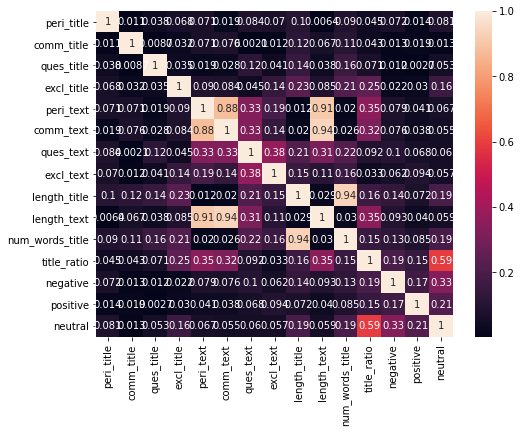

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(np.abs(X_train_punct_len.corr()), annot=True)
plt.savefig('correlation')
plt.show()

* huge correlation between `peri_text` and `length_text`

* huge correlation between `comm_text` and `length_text`

* huge correlation between `comm_text` and `peri_text`

* huge correlation between `peri_test` and `num_words_text`

...and so on

We have to find out how they interact with the target to determine what to do with them.

## How do they Interact with the Target?

In [ ]:
pd.concat([X_train_punct_len, y_train], axis=1).groupby('is_fake').mean()

peri_title  comm_title  ques_title  ...  negative  positive   neutral
is_fake                                      ...                              
0          0.464354    0.248557    0.006645  ...  0.110095  0.124911  0.764993
1          0.097692    0.203592    0.073762  ...  0.141166  0.145385  0.683172

[2 rows x 15 columns]

**Main Findings:**
* Titles of Fake News contain ~4 times less `periods`

* Titles of Fake News contain ~10 times more `question marks`

* Titles of Fake News contain ~130 times more `exclamation marks` **(wow!)**

* Texts of Fake News contain ~10 times more `question marks` 

* Texts of Fake News contain ~10 times more `exclamation marks`

* Titles of Fake News are 50% `longer`. The number of words seems to reflect that fact as well. -> The length of words in the titles of Fake News and real News don't seem to vary a lot.

* $\frac{len(title)}{len(title) + len(text)}$ is ~40% longer in Fake News

* Let's ignore the high correlations we found above. A more elaborate approach would be to eliminate correlating features by dropping them or using dimensionality reduction like PCA

# Apply Naive Bayes( ACC: 66%)

In [173]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [27]:
# Naive Bayes Model
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [174]:
nb = MultinomialNB()
nb.fit(X_train_punct_len, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [110]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [175]:
preds_test = nb.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc*100}')

f1: 0.6967378171566653
acc: 66.45879732739421


In [176]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, preds_test)
print(f'acc: {acc*100}')
# precision tp / (tp + fp)
precision = precision_score(y_test, preds_test)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, preds_test)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, preds_test)
print('F1 score: %f' % f1)

acc: 66.45879732739421
Precision: 0.657670
Recall: 0.740741
F1 score: 0.696738


In [177]:
cm= confusion_matrix(y_test, preds_test)

In [178]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

In [45]:
import seaborn as sns

Text(24.0, 0.5, 'Actual')

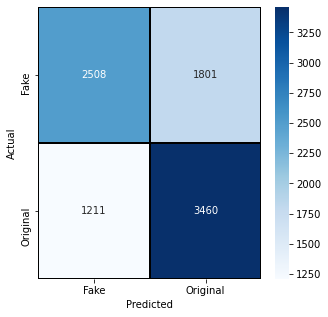

In [179]:

plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Logistic Regression ( 86.4%)

In [180]:
from sklearn.linear_model import LogisticRegression

# Train the model
lr = LogisticRegression()
lr.fit(X_train_punct_len, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [181]:
preds_test = lr.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.8094741235392321
acc: 0.7966592427616926


In [182]:
confusion_matrix(y_test, preds_test)

array([[3275, 1034],
       [ 792, 3879]])

In [ ]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, preds_test, labels=[0, 1]))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(y_test, preds_test, labels=[0, 1]))

[[3661  601]
 [1022 3696]]
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      4262
           1       0.86      0.78      0.82      4718

    accuracy                           0.82      8980
   macro avg       0.82      0.82      0.82      8980
weighted avg       0.82      0.82      0.82      8980



# Random Forest
Let's use a default RandomForest for our classification!

In [133]:

from sklearn.ensemble import RandomForestClassifier
# Train the model
rf = RandomForestClassifier()
rf.fit(X_train_punct_len, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [134]:
preds_test = rf.predict(X_test_punct_len) 
f1 = f1_score(y_true=y_test, y_pred=preds_test)
acc = accuracy_score(y_true=y_test, y_pred=preds_test)
print(f'f1: {f1}\nacc: {acc}')

f1: 0.9419423692636073
acc: 0.9394209354120268


In [135]:
confusion_matrix(y_test, preds_test)

array([[4023,  243],
       [ 301, 4413]])

# How well can we predict on subsets of the Features?

In [ ]:
forest = RandomForestClassifier(random_state=42)

best_column = 'all'
best_score = 0
for column in X_train_punct_len.columns:
    forest.fit(X_train_punct_len[column].values.reshape((-1,1)), y_train)
    preds = cross_val_predict(forest, X_train_punct_len[column].values.reshape((-1,1)), y_train, cv=5)
    f1 = f1_score(y_true=y_train, y_pred=preds)
    
    if(f1>best_score):
        best_score = f1
        best_column = column

print(f'A default RandomForest already obtains an f1-score of {f1} on validation data when trained solely on the column {column}')

In [ ]:
forest = RandomForestClassifier(random_state=42)
punctuation = ['peri_title', 'comm_title', 'ques_title', 'excl_title', 'peri_text', 'comm_text', 'ques_text', 'excl_text']
lenght = ['length_title', 'length_text','num_words_title', 'title_ratio']


forest.fit(X_train_punct_len[punctuation], y_train)
preds = cross_val_predict(forest, X_train_punct_len[punctuation], y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
print(f'A default RandomForest already obtains an f1-score of {f1} when trained solely on punctuation-based Features')
print('The Feature Inportances in that approach are:')
print(pd.Series(forest.feature_importances_, 
          index=punctuation).sort_values(ascending=False))

forest.fit(X_train_punct_len[lenght], y_train)
preds = cross_val_predict(forest, X_train_punct_len[lenght], y_train, cv=5)
f1 = f1_score(y_true=y_train, y_pred=preds)
print(f'A default RandomForest already obtains an f1-score of {f1} when trained solely on length-based Features')
print('The Feature Importances in that approach are:')
print(pd.Series(forest.feature_importances_, 
          index=lenght).sort_values(ascending=False))

As we saw, even some basic feature engineering might reveal powerful features for our machine learning models. I am pretty sure that adding `Word Embeddings` will improve the performance by a lot.

Thank you for reading this notebook!